In [9]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import textwrap

from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

# Load Data

In [10]:
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
print(f"{gf.shape=}")


df.head()

df.shape=(19393, 18)
df.shape=(19235, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19235


/tmp/ipykernel_2308510/4036917658.py:23: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(gene_path, gene_names)


gf.shape=(19235, 2)


,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,12,5,5,9,2,6,7,3,6,5,5,5,4,3,4,5,5,3
A1CF,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0
A2M,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,2
A2ML1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# choose DMD Rank

In [11]:
target = 1e6
threshold = 0.5
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
high_exp_genes = tpm_dist[(tpm_dist > threshold)].index.to_list()    

percent_kept = len(high_exp_genes) / len(tpm_dist)
print(f"{percent_kept=}")

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data = nb.data2DMD(d) 
print(f"{dmd_data.shape=}")

results = {}

for i, rank in enumerate(np.arange(1, 11, 1)):
    print(f"{rank=}")
    dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)
    results[rank] = dmd_res.copy()

print('done')

percent_kept=0.421731219131791
dmd_data.shape=(8112, 8, 2)
rank=1
rank=2
rank=3
rank=4
rank=5
rank=6
rank=7
rank=8
rank=9
rank=10
done


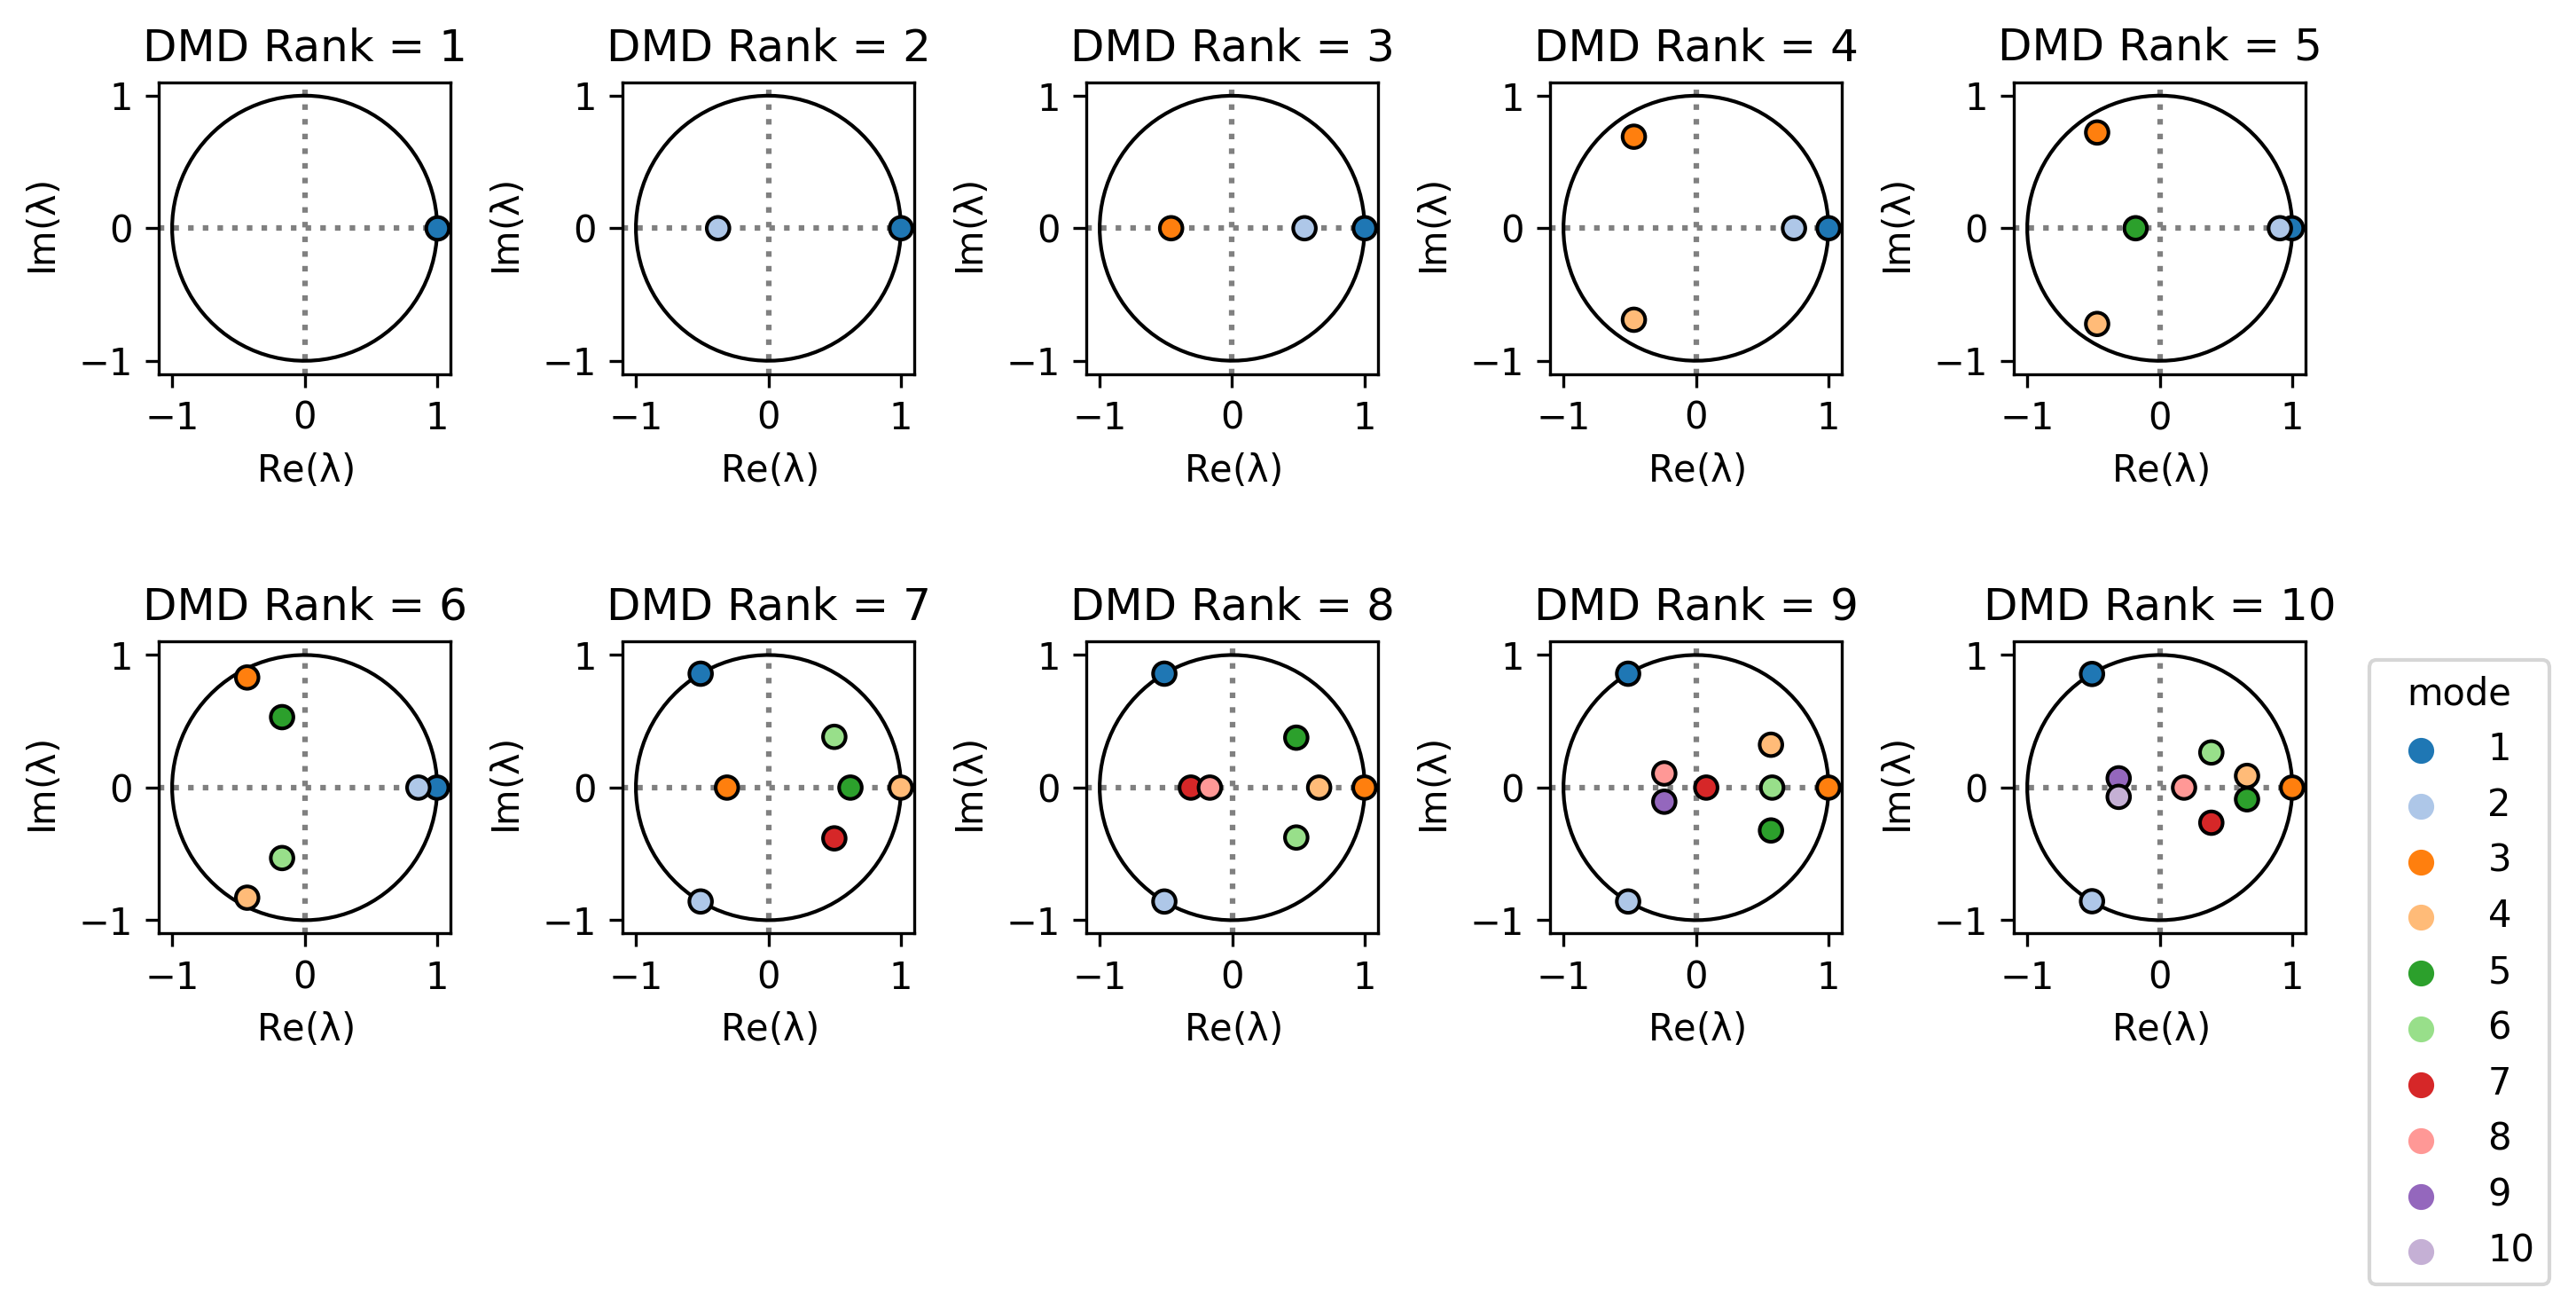

In [12]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, (rank, dmd_res) in enumerate(results.items()):

    L = dmd_res['L']

    # make the unit circle
    axs[i].plot(np.cos(np.linspace(0, np.pi*2, 100)), 
                np.sin(np.linspace(0, np.pi*2, 100)), 
                linewidth=1, 
                c='k',
                zorder=1)

    # add the axis
    axs[i].axvline(x=0, ls=":", c='grey', zorder=0)
    axs[i].axhline(y=0, ls=":", c='grey', zorder=0)

    pdf = pd.DataFrame({'real' : np.real(L),
                        'imaginary' : np.imag(L)})
    
    pdf['mode'] = list(range(1, rank+1))

    # plot the eigenvalues
    sns.scatterplot(data=pdf,
                    x='real', 
                    y='imaginary',
                    s=150,
                    marker=".",
                    hue='mode',
                    ec='k',
                    ax=axs[i],
                    palette='tab20',
                    zorder=3)

    axs[i].set_aspect('equal')
    axs[i].set_title(f"DMD Rank = {rank}")
    axs[i].set_xlabel(r'$\mathregular{Re(\lambda)}$')
    axs[i].set_ylabel(r'$\mathregular{Im(\lambda)}$')
    if i == 9:
        sns.move_legend(axs[i],
                        loc='upper right',
                        bbox_to_anchor=(1.9, 1),
                        )
    else:
        axs[i].legend().remove()

# fig.delaxes(axs[14])
plt.tight_layout()

In [13]:
# evaluate the predictive accuracy

gene_labels = pd.DataFrame(high_exp_genes, columns=['gene_name'])

res = []
cd_list = []

for i, (rank, dmd_res) in enumerate(results.items()):
    X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    print(f"{rank=} {cd=}")
    t_res = hasnain_DMD.sample_correlations(gene_labels, dmd_data, X_pred)

    row = {
        'rank' : rank,
        'cd' : cd,
    }
    cd_list.append(row)
    

    t_res['rank'] = rank
    res.append(t_res)


res = pd.concat(res)
print(res.head())

rank=1 cd=-0.1138233357722136
rank=2 cd=-0.05857073588305517
rank=3 cd=0.06147101736673355
rank=4 cd=0.883221738267309
rank=5 cd=0.8819288557157073
rank=6 cd=0.9798654830255168
rank=7 cd=0.9988895320775797
rank=8 cd=0.9982999087540998
rank=9 cd=0.9978001266838133
rank=10 cd=0.9981074112175691
     gene      corr      pval  rank
0  A4GALT -0.665458  0.071689     1
1    AAAS -0.072413  0.864699     1
2    AACS -0.798222  0.017556     1
3   AAGAB  0.530717  0.175970     1
4    AAMP -0.752213  0.031316     1


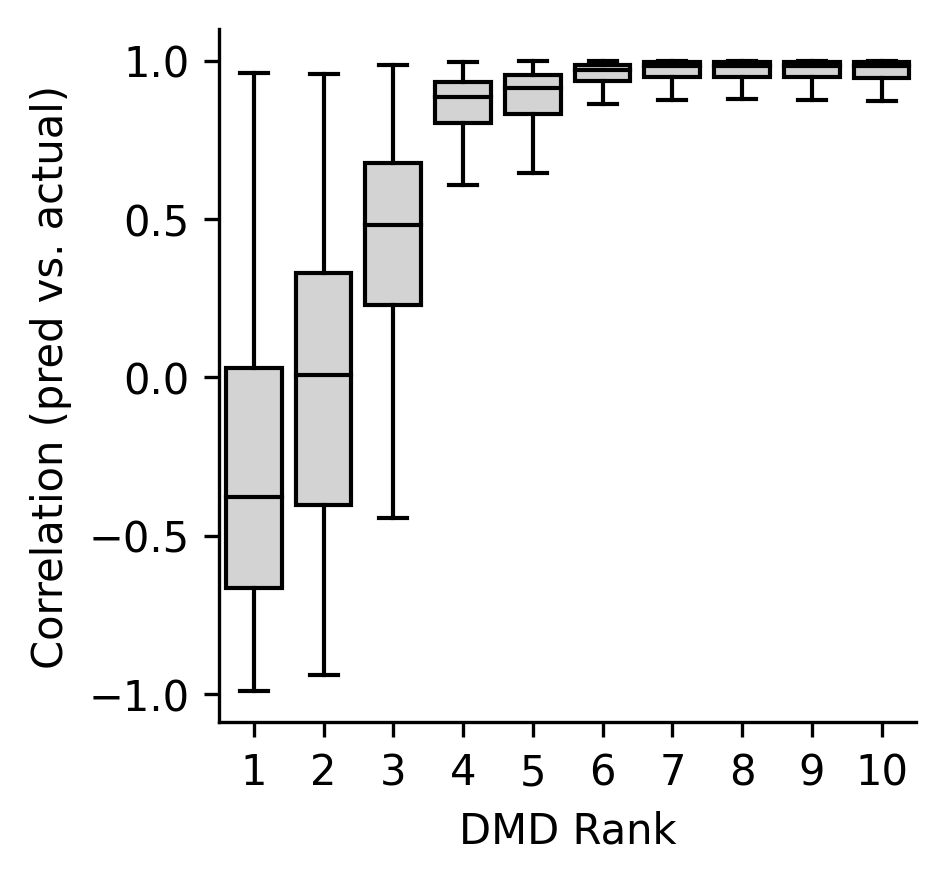

In [14]:

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.boxplot(data=res, 
            x='rank',
            y='corr',
            color='lightgrey',
            showfliers=False,
            whiskerprops={"color": "k", "lw" : 1},
            capprops={"color": "k", "lw" : 1},
            boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
            medianprops={"color": "k", "lw" : 1},
            )

plt.ylabel("Correlation (pred vs. actual)")
plt.xlabel("DMD Rank")
sns.despine()

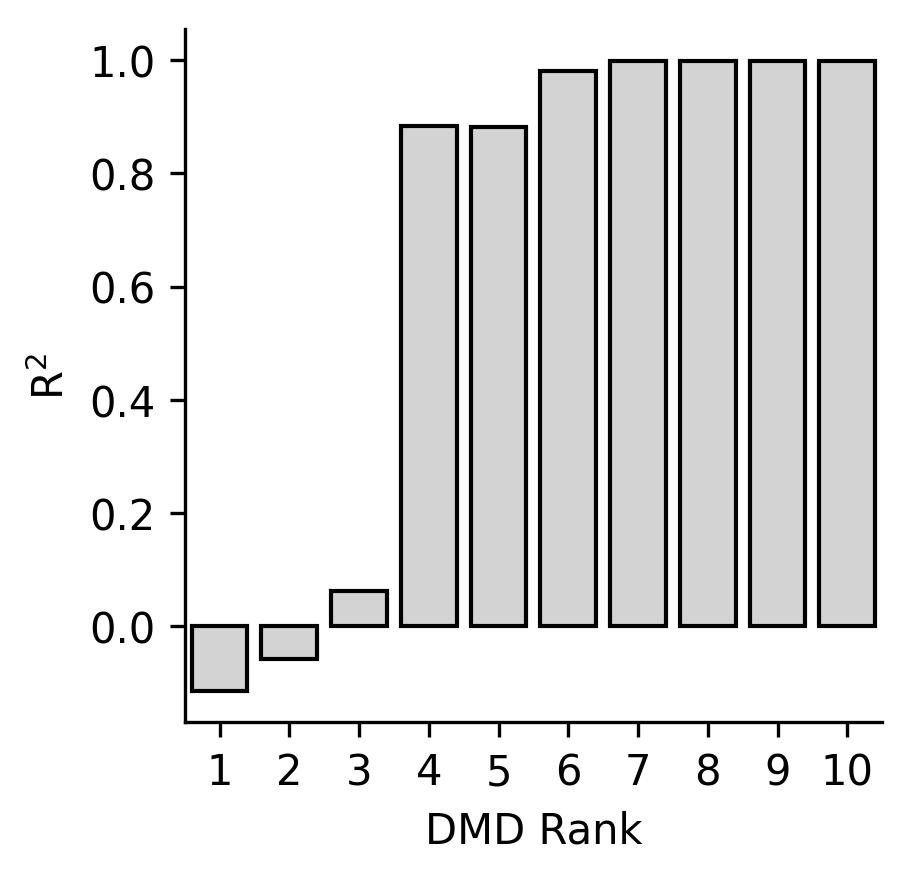

In [15]:
pdf = pd.DataFrame(cd_list)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.barplot(pdf, 
            x='rank',
            y='cd',
            color='lightgrey', 
            ec='k')

plt.ylabel(r"R$^2$")
plt.xlabel("DMD Rank")
sns.despine()

In [16]:
# break